In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [2]:
df = [['size', 'bedrooms', 'price'],[2104, 3, 400], [1416, 2, 232], [1534, 3, 315], [843, 2, 178]]
data = pd.DataFrame(data=df[1:][:], columns=df[0][:])

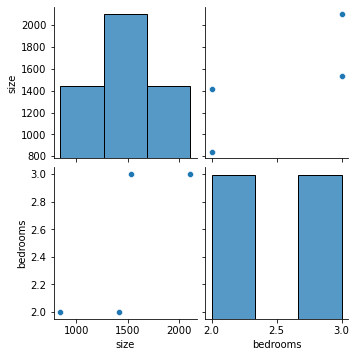

In [3]:
sb.pairplot(data[['size', 'bedrooms']]);

In [4]:
Y = data.pop('price')
X = data

In [12]:
class LinearModel:
    def __init__(self, n):
        self.thetas = np.random.uniform(-1, 1, (n + 1, 1))
        
    def normalize(self, X):
            
        pass
    
    def train(self, X, Y):
        data = self.normalize(X)
        for i,j in enumerate(X):
            print(Y[i],j)
        pass
        

In [13]:
A = LinearModel(2)
A.train(np.array(X), np.array(Y))


400 [2104    3]
232 [1416    2]
315 [1534    3]
178 [843   2]
